# Proyecto End to End: Iris Dataset

Alumno: Luis Raúl Sigala González 

Matrícula: 309183

Asesor: Olanda Prieto Ordaz

Materia: Machine Learning

## Librerias

In [103]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn import datasets


## Conjunto de datos

In [69]:

iris = datasets.load_iris()
iris_df = pd.DataFrame(data= np.c_[iris['data'], iris['target']],
                     columns= iris['feature_names'] + ['target'])

Visualizar Head del dataframe y obtener un resumen de su información

In [70]:
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0.0
1,4.9,3.0,1.4,0.2,0.0
2,4.7,3.2,1.3,0.2,0.0
3,4.6,3.1,1.5,0.2,0.0
4,5.0,3.6,1.4,0.2,0.0


In [71]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    float64
dtypes: float64(5)
memory usage: 6.0 KB


In [72]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


## Exploración de los datos

Datos en donde no se presenta la información

In [73]:
iris_df.isna().sum()

sepal length (cm)    0
sepal width (cm)     0
petal length (cm)    0
petal width (cm)     0
target               0
dtype: int64

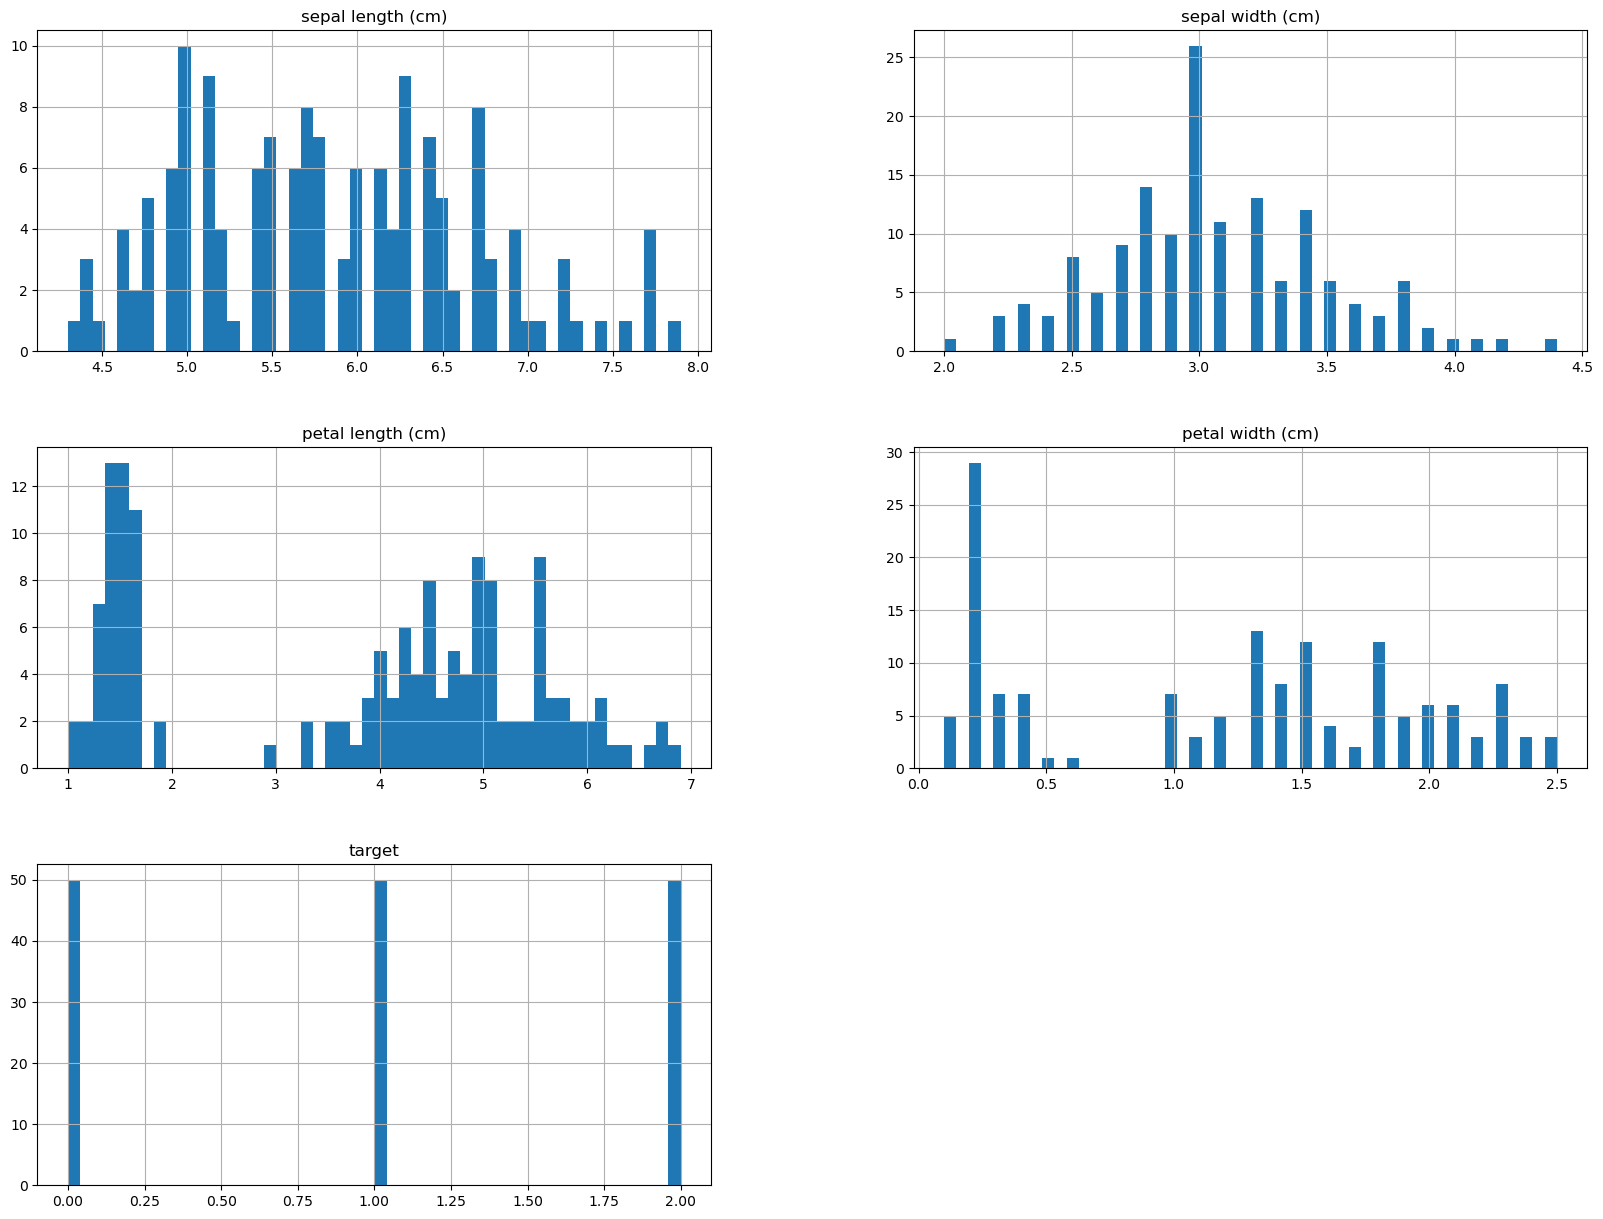

In [74]:
iris_df.hist(bins=50, figsize=(20,15))
plt.show()

Grafica de la distribucion de los datos

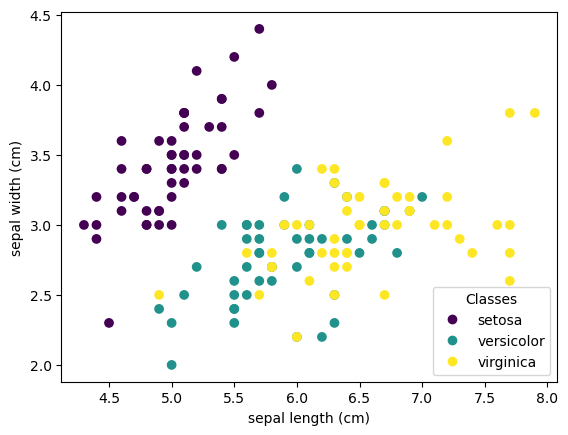

In [75]:
_, ax = plt.subplots()

scatter = ax.scatter(iris_df.iloc[:, 0], iris_df.iloc[:, 1], c=iris_df['target'])
ax.set(xlabel=iris_df.columns[0], ylabel=iris_df.columns[1])
_ = ax.legend(
    scatter.legend_elements()[0], iris.target_names, loc="lower right", title="Classes"
)

plt.show()

Correlacion de los datos con nuestro target

In [36]:
corr_matrix = iris_df.corr()

In [37]:
corr_matrix['target'].sort_values(ascending=False)

target               1.000000
petal width (cm)     0.956547
petal length (cm)    0.949035
sepal length (cm)    0.782561
sepal width (cm)    -0.426658
Name: target, dtype: float64

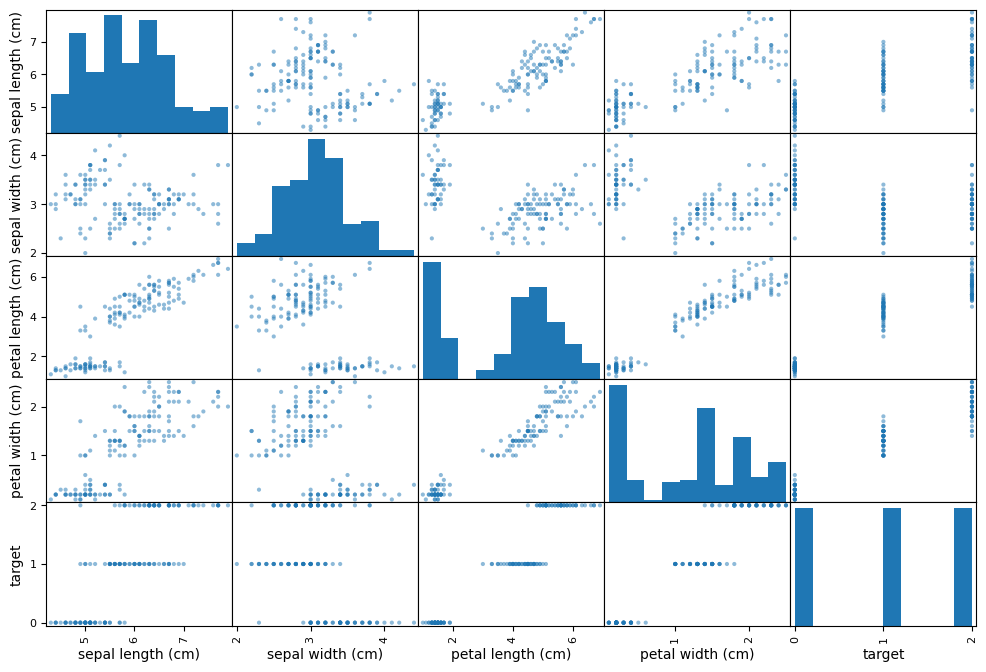

In [38]:
scatter_matrix(frame=iris_df, figsize=(12, 8))
plt.show()

Grafica del resultado con mayor correlación al resultado

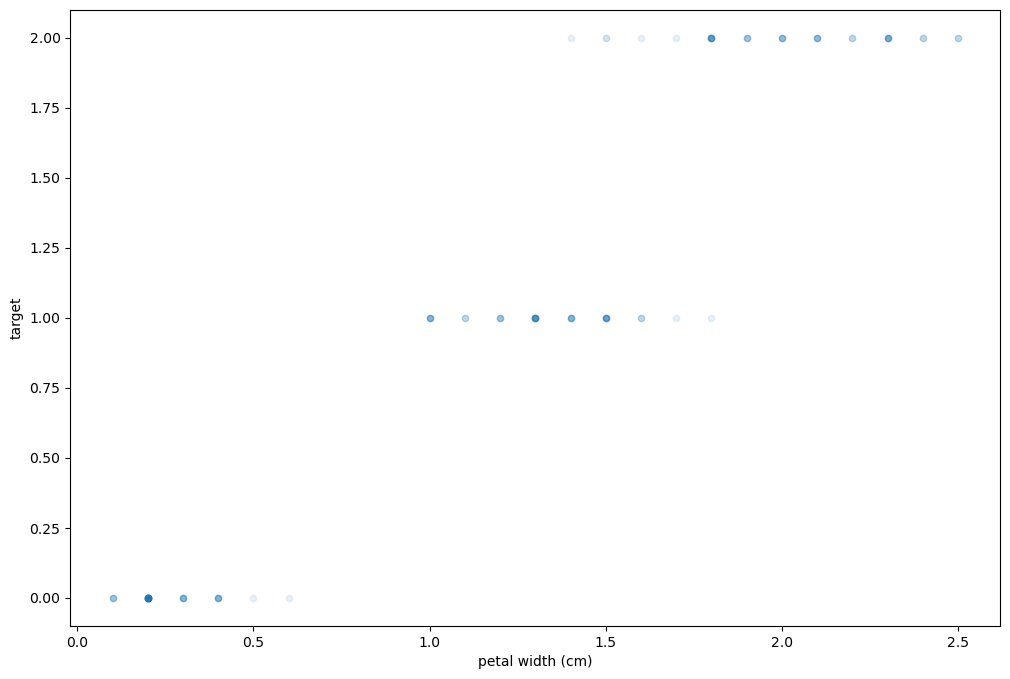

In [39]:
iris_df.plot(kind='scatter', x='petal width (cm)', y='target', figsize=(12,8), alpha=0.1)
plt.show()

## Preparar nuestro dataset para el modelo de aprendizaje

Según lo aprendido con las pruebas anteriores crear funciones para preparar el dataframe antes de entrar al modelo de aprendizaje

En este caso la base datos no tiene datos con valores nulos y su información presenta una correlación alta con el target, solo se agrega un StandardScaler para normalizar nuestros datos.

In [85]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

In [86]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline,['sepal length (cm)',	'sepal width (cm)',	'petal length (cm)','petal width (cm)']),
    ]
)

Creación de Split Train y Test con estratificado segun la columna del target.

In [87]:
X_train, X_test, y_train, y_test = train_test_split(
        iris_df.drop(columns='target'), iris_df['target'], test_size=0.2, random_state=42, stratify=iris_df['target']
    )



c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [88]:
conteo_clases = y_train.value_counts().to_dict()
print(conteo_clases)
conteo_clases = y_test.value_counts().to_dict()
print(conteo_clases)

{0.0: 40, 2.0: 40, 1.0: 40}
{0.0: 10, 2.0: 10, 1.0: 10}


## Seleccion de modelo y ajuste fino con Grid Search

Creacion de pipeline con transformador y modelo

In [104]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('logistic', LogisticRegression())  # Cambiamos a SVC
])

Parametros y GridSearch

In [105]:
param_grid = {
    'logistic__C': [0.1, 1, 10, 100],  # Parametro de regularización
    'logistic__solver': ['liblinear', 'lbfgs']  # Optimizador
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

Entrenamiento del modelo

In [106]:
# Busqueda de las mejores caracteristicas para el clasificado
grid_search.fit(X_train, y_train)
# guardar el mejor modelo a un archivo .pkl
best_pipeline = grid_search.best_estimator_
joblib.dump(best_pipeline, 'pipeline.pkl')


c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

['pipeline.pkl']

## Prueba del modelo con grupo test

In [107]:
y_pred = best_pipeline.predict(X_test)

c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


Best Parameters: {'logistic__C': 10, 'logistic__solver': 'lbfgs'}
Accuracy Score: 1.0

Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        10
         1.0       1.00      1.00      1.00        10
         2.0       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\sigal\anaconda3\envs\EEG\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(p

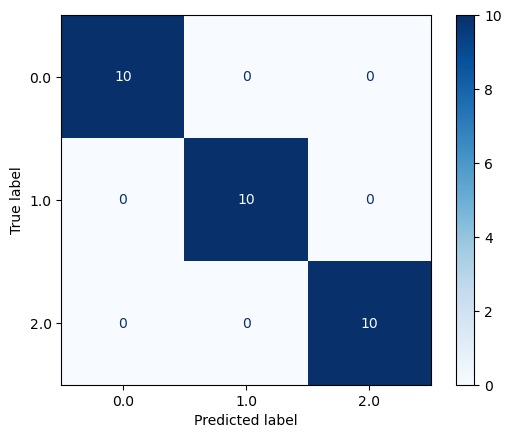

In [108]:
print("Best Parameters:", grid_search.best_params_)
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred, labels=grid_search.best_estimator_.classes_)

# Crear y mostrar la visualización de la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search.best_estimator_.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.show()

## Deployment del modelo en Streamlit

https://tareasml-hnwujim8wzmqbqhhzhiwtn.streamlit.app/

https://github.com/lrsigala/TareasML